In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import os

from dotenv import load_dotenv

In [3]:
load_dotenv(dotenv_path="../.env")

S3_REGION = os.getenv('S3_REGION')
S3_ENDPOINT = os.getenv('S3_ENDPOINT')
S3_ACCESS_KEY_ID = os.getenv('S3_ACCESS_KEY_ID')
S3_SECRET_ACCESS_KEY = os.getenv('S3_SECRET_ACCESS_KEY')

client = boto3.client('s3',
                    region_name=S3_REGION,
                    endpoint_url=S3_ENDPOINT,
                    aws_access_key_id=S3_ACCESS_KEY_ID,
                    aws_secret_access_key=S3_SECRET_ACCESS_KEY,)

In [4]:
response = client.list_objects(
        Bucket='csv-store',
        Prefix='matic-data'
    )

csv_files = [obj.get("Key") for obj in response.get("Contents") if obj.get("Key").endswith(".csv")]

In [5]:
def fetch_and_read_csv(client, key):
    res = client.get_object(Bucket="csv-store", Key=key)
    try:
        df = pd.read_csv(res.get("Body"), index_col=None, header=None, names=[
            "block number", "timestamp", "contract address", "from", "to", "value"])
    except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(message)
    else:
        return df
    
try: 
    df = pd.concat(map(lambda csv_file: fetch_and_read_csv(client=client, key=csv_file), csv_files), axis=0, ignore_index=True)
except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(message)
else:
        df['datetime'] = pd.to_datetime(df['timestamp'])
        df.sort_values(["timestamp", "from", "value"], inplace=True)


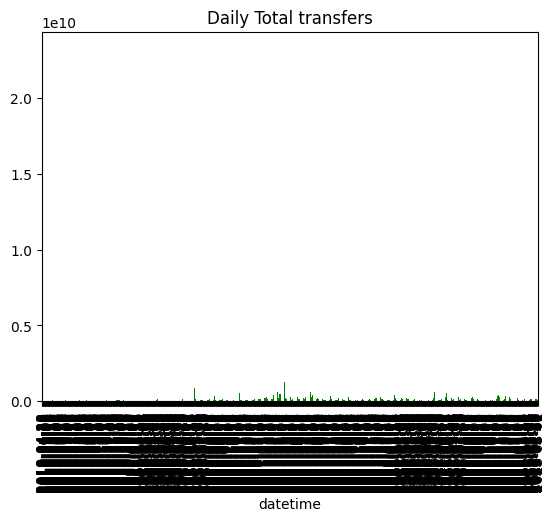

In [6]:
sumDf = df.groupby(df.datetime.dt.date)['value'].sum()

sumDf.plot(kind='bar',
        x=0,
        y=1,
        color='green',
        title='Daily Total transfers',
        # ylim=(0, 2200000000.0)
        )

# show the plot
plt.show()